Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/credit-card-fraud-detection/credit_card_fraud_dataset.csv


Read the credit card fraud dataset from a CSV file

In [3]:
df = pd.read_csv('/kaggle/input/credit-card-fraud-detection/credit_card_fraud_dataset.csv')
df.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


Get the data types of each column in the DataFrame


In [4]:
df.dtypes

TransactionID        int64
TransactionDate     object
Amount             float64
MerchantID           int64
TransactionType     object
Location            object
IsFraud              int64
dtype: object

Copy the dataframe 'df' to a new dataframe 'df1'

In [5]:
df1 = df.copy()

Display the first 5 rows of the DataFrame df1

In [6]:
df1.head(10)

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0
5,6,2024-08-30 01:52:35.462867,3086.22,302,purchase,New York,0
6,7,2024-01-02 11:31:35.462875,1466.90,902,refund,Philadelphia,0
7,8,2024-05-12 12:25:35.462885,917.21,266,purchase,New York,0
8,9,2023-11-16 02:20:35.462894,1625.73,32,refund,Chicago,0
9,10,2023-10-24 06:51:35.462901,662.07,193,purchase,Dallas,0


In [7]:
df1.tail(10)

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
99990,99991,2024-01-12 17:50:36.027574,2883.93,231,refund,New York,0
99991,99992,2024-05-28 18:52:36.027577,2173.73,93,purchase,Dallas,0
99992,99993,2024-05-25 06:21:36.027581,3743.94,414,purchase,Chicago,0
99993,99994,2024-04-20 15:33:36.027584,614.02,625,refund,Phoenix,0
99994,99995,2024-02-26 21:22:36.027587,53.49,2,refund,Philadelphia,0
99995,99996,2024-06-07 00:57:36.027591,1057.29,289,refund,San Antonio,0
99996,99997,2023-10-22 23:12:36.027594,297.25,745,refund,San Antonio,0
99997,99998,2024-05-31 19:27:36.027597,3448.56,690,purchase,San Antonio,0
99998,99999,2024-10-18 09:43:36.027601,3750.79,644,purchase,Philadelphia,0
99999,100000,2024-03-05 19:41:36.027606,1596.79,675,refund,Houston,0


Calculate the z-score for each row in the 'Amount' column of df1

In [8]:
df1['z_score'] = (df1['Amount'] - df1['Amount'].mean()) / df1['Amount'].std()
outliers = df1[np.abs(df1['z_score']) > 3]
print(outliers)

Empty DataFrame
Columns: [TransactionID, TransactionDate, Amount, MerchantID, TransactionType, Location, IsFraud, z_score]
Index: []


In [9]:
df1['TransactionDate'] = pd.to_datetime(df1['TransactionDate'])
df1['TransactionYear'] = df1['TransactionDate'].dt.year
df1['TransactionMonth'] = df1['TransactionDate'].dt.month
df1['Transactionhour'] = df1['TransactionDate'].dt.hour

In [10]:
df1.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud,z_score,TransactionYear,TransactionMonth,Transactionhour
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0,1.173155,2024,4,14
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0,0.112740,2024,3,13
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0,-1.187655,2024,1,10
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0,0.705280,2024,4,23
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0,-1.475318,2024,7,18


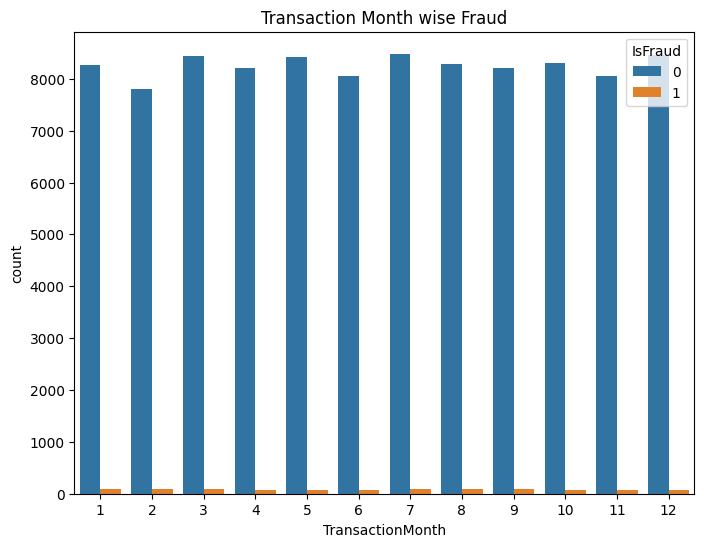

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='TransactionMonth', hue='IsFraud', data=df1)
plt.title('Transaction Month wise Fraud')
plt.show()

In [12]:
df1['IsFraud'].value_counts()

IsFraud
0    99000
1     1000
Name: count, dtype: int64

In [13]:
df1['IsFraud'].value_counts(normalize=True)

IsFraud
0    0.99
1    0.01
Name: proportion, dtype: float64

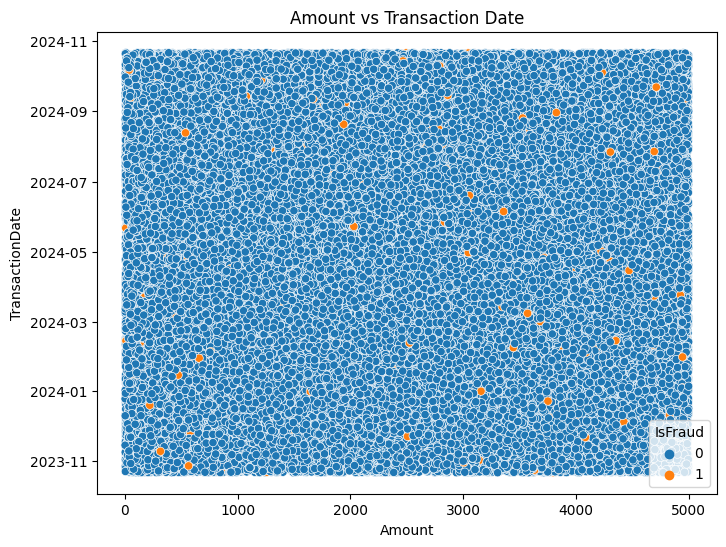

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Amount', y='TransactionDate', hue='IsFraud', data=df1)
plt.title('Amount vs Transaction Date')
plt.show()

In [15]:
x = df.drop(['IsFraud','TransactionDate',], axis=1)
y = df['IsFraud']

In [16]:
int_col = [col for col in x.columns if x[col].dtype in ['int64','float64','int32']]
cat_col = [col for col in x.columns if x[col].dtype == 'object']

In [17]:
num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                  ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                ('encoder', OneHotEncoder(handle_unknown='ignore'))])


In [18]:
preprocessor = ColumnTransformer(transformers=[('num',num_transformer,int_col),
                                              ('cat', cat_transformer,cat_col)])

In [19]:
x_transformed = preprocessor.fit_transform(x)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x_transformed, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
classifier = {'RandomForestClassifier': RandomForestClassifier(random_state=42),
             'LogisticRegression': LogisticRegression(random_state=42),
             'XGBoostClassifier': XGBClassifier(random_state=42),
             'LightGBMClassifier': LGBMClassifier(random_state=42)}

In [23]:
params = {'RandomForestClassifier':{
    'class_weight': [None, 'balanced']
},
'LogisticRegression':{
    'class_weight': [None, 'balanced']
    
},
'XGBoostClassifier':{},
'LightGBMClassifier':{
    'class_weight': [None, 'balanced']
}
}

In [24]:
best_models = {}
for model_name, model in classifier.items():
    print(f'Running {model_name}...')
    GridSearch = GridSearchCV(estimator=model,
                              param_grid=params[model_name],
                              cv=skf,
                              scoring='accuracy',
                              n_jobs=-1,
                              verbose=2)
    GridSearch.fit(x_train, y_train)
    best_models[model_name] = GridSearch.best_estimator_


Running RandomForestClassifier...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running LogisticRegression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Running XGBoostClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running LightGBMClassifier...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Info] Number of positive: 79200, number of negative: 79200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 158400, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [25]:
y_pred = best_models[model_name].predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.68      0.81     19800
           1       0.01      0.34      0.02       200

    accuracy                           0.68     20000
   macro avg       0.50      0.51      0.41     20000
weighted avg       0.98      0.68      0.80     20000



In [26]:
y_prob = best_models[model_name].predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {auc_score:.2f}")

ROC-AUC Score: 0.51


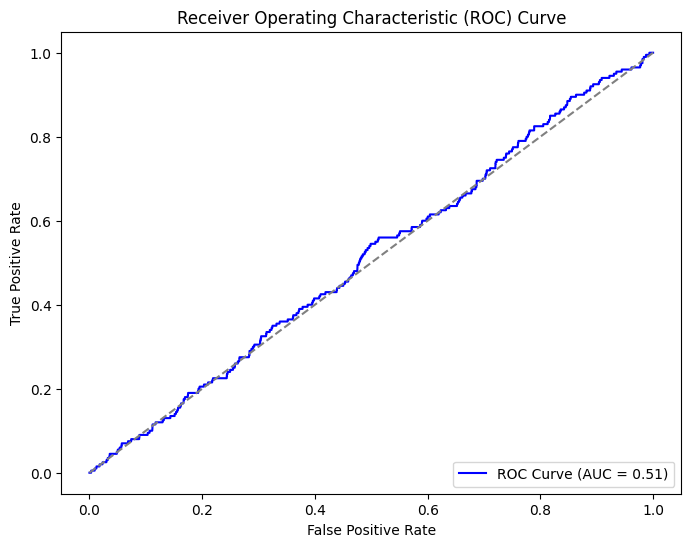

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)  # Calculate False Positive Rate and True Positive Rate

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random chance)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
